# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
labels = ["nPH", "nPN"]
nmax = 4

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

Welcome to JupyROOT 6.18/04


In [3]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")

## Example Fit / Calibration & Prediction

In [5]:
model = Bayes(traindata, nmax, labels[0])
y_pred = model.predict(testdata)
y_true = testdata[labels[0]].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(2, 2), (3, 3), (4, 4), (1, 1), (3, 3), (4, 3), (1, 1), (1, 1), (1, 1), (3, 3), (2, 1), (1, 1), (4, 4), (4, 2), (3, 3), (2, 2), (2, 1), (4, 4), (3, 3), (3, 4), (3, 2), (2, 2), (1, 1), (1, 1), (1, 1), (4, 4), (3, 3), (3, 3), (1, 1), (2, 2), (1, 1), (1, 1), (1, 1), (3, 4), (1, 1), (4, 4), (1, 1), (4, 4), (2, 2), (4, 3), (2, 2), (3, 3), (2, 2), (4, 4), (1, 2), (1, 1), (2, 3), (1, 1), (2, 2), (2, 2)]


In [6]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.7881917403655068
[[ 2106     0     1     1     2]
 [    0 38078  3864    20     6]
 [    0  5836 29062  7032   121]
 [    2   310  7884 24300  8945]
 [    2    11   643  7236 24727]]
[[100.   0.   0.   0.   0.]
 [  0.  91.   9.   0.   0.]
 [  0.  14.  69.  17.   0.]
 [  0.   1.  19.  59.  22.]
 [  0.   0.   2.  22.  76.]]


Text(69.0, 0.5, 'True')

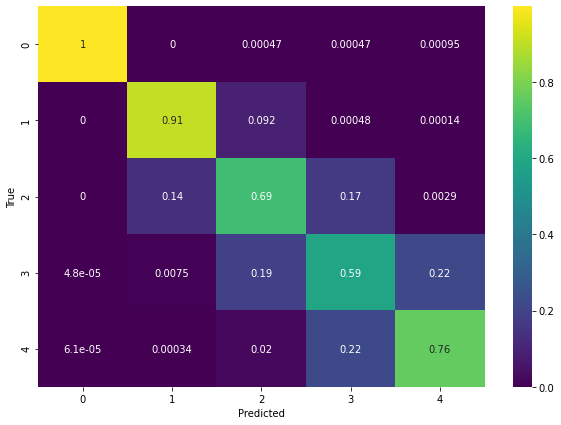

In [7]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [8]:
for n in [1, 2, 3, 4, 5]:
    for label in labels:
        traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=n, physics="inclxx")

        model = Bayes(traindata, n, label)
        y_pred = model.predict(testdata)
        y_true = testdata[label].values.ravel()

        bac = balanced_accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
        print(n, label, bac)
        print(cm)
        print("\n")

1 nPH 0.999406771266102
[[ 1995     2]
 [    7 37840]]


1 nPN 0.9999475918452911
[[ 2081     0]
 [    4 38158]]


2 nPH 0.9222903234607053
[[ 1992     1     1]
 [    3 37908  3942]
 [   10  4932 30904]]


2 nPN 0.8942235203033818
[[ 2098     0     0]
 [    6 33804  4325]
 [    7  8080 31602]]


3 nPH 0.8494178161305854
[[ 2090     2     1     2]
 [    2 38031  3940    28]
 [    2  5767 28769  6920]
 [    3   246  6578 27419]]


3 nPN 0.808713929611506
[[ 2075     0     0     0]
 [    3 33906  4201    37]
 [    1  8053 23985  7860]
 [    3  1186  9029 29835]]


4 nPH 0.7882992224201311
[[ 2035     2     0     0     1]
 [    1 38428  3877    21    11]
 [    1  5789 29016  6929   116]
 [    2   317  7732 24054  9203]
 [    3    13   585  7275 24899]]


4 nPN 0.7393387181330434
[[ 2068     0     0     0     0]
 [    1 33894  4195    32    10]
 [    1  8198 24015  7625   243]
 [    1  1221  9031 19888  9904]
 [    1   145  1941  9428 28474]]


5 nPH 0.7383829477081062
[[ 2062     2     0  